In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Packages and imports

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import torch

In [3]:
!pip install torch_geometric -q
!pip install torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 28.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 19.6 MB/s eta 0:00:00


Visualize function

In [4]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.cpu().detach().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# Graph

## Edges

In [5]:
edges = pd.read_csv('/content/drive/MyDrive/TAI/III/gnn/data/twitch_gamers/large_twitch_edges.csv')
edges

,numeric_id_1,numeric_id_2
0,98343,141493
1,98343,58736
2,98343,140703
3,98343,151401
4,98343,157118
...,...,...
6797552,97507,29359
6797553,71175,12020
6797554,151702,128281
6797555,118034,38021


## Create graph

In [6]:
G = nx.from_pandas_edgelist(edges, source='numeric_id_1', target='numeric_id_2')
print(G)

Graph with 168114 nodes and 6797557 edges


### Degree embeddings

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch

# using degree as embedding
embeddings = np.array(list(dict(G.degree()).values()))

# normalizing degree values
scale = MinMaxScaler()
embeddings = scale.fit_transform(embeddings.reshape(-1,1))

## Nodes

In [8]:
nodes = pd.read_csv('/content/drive/MyDrive/TAI/III/gnn/data/twitch_gamers/large_twitch_features.csv')
nodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168114 entries, 0 to 168113
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   views         168114 non-null  int64 
 1   mature        168114 non-null  int64 
 2   life_time     168114 non-null  int64 
 3   created_at    168114 non-null  object
 4   updated_at    168114 non-null  object
 5   numeric_id    168114 non-null  int64 
 6   dead_account  168114 non-null  int64 
 7   language      168114 non-null  object
 8   affiliate     168114 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 11.5+ MB


### Create features

In [9]:
nodes.created_at = pd.to_datetime(nodes.created_at)
nodes.updated_at = pd.to_datetime(nodes.updated_at)
nodes['created_at_year'] = nodes['created_at'].dt.year
nodes['created_at_month'] = nodes['created_at'].dt.month
nodes['created_at_day'] = nodes['created_at'].dt.day
nodes['updated_at_year'] = nodes['updated_at'].dt.year
nodes['updated_at_month'] = nodes['updated_at'].dt.month
nodes['updated_at_day'] = nodes['updated_at'].dt.day
nodes = pd.get_dummies(nodes, columns=['language'])
nodes = nodes.drop(columns=['created_at', 'updated_at'])


nodes["embeddings"] = embeddings

## Normalization

MinMax Normalization

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch

In [11]:
# normalizing degree values
scale = MinMaxScaler()
nodes['views'] = scale.fit_transform(nodes['views'].values.reshape(-1,1))
nodes['life_time'] = scale.fit_transform(nodes['life_time'].values.reshape(-1,1))
nodes['created_at_year'] = scale.fit_transform(nodes['created_at_year'].values.reshape(-1,1))
nodes['updated_at_year'] = scale.fit_transform(nodes['updated_at_year'].values.reshape(-1,1))
nodes['created_at_month'] = scale.fit_transform(nodes['created_at_month'].values.reshape(-1,1))
nodes['updated_at_month'] = scale.fit_transform(nodes['updated_at_month'].values.reshape(-1,1))
nodes['created_at_day'] = scale.fit_transform(nodes['created_at_day'].values.reshape(-1,1))
nodes['updated_at_day'] = scale.fit_transform(nodes['updated_at_day'].values.reshape(-1,1))

## Set index

In [12]:
nodes = nodes.set_index(['numeric_id'])

## Final nodes dataframe

In [13]:
nodes

,views,mature,life_time,dead_account,affiliate,created_at_year,created_at_month,created_at_day,updated_at_year,updated_at_month,...,language_NO,language_OTHER,language_PL,language_PT,language_RU,language_SV,language_TH,language_TR,language_ZH,embeddings
numeric_id,,,,,,,,,,,,,,,,,,,,,
0,0.000020,1,0.230843,0,1,0.818182,0.090909,0.500000,1.0,0.818182,...,0,0,0,0,0,0,0,0,0,0.001077
1,0.000001,0,0.647711,0,0,0.363636,0.363636,0.600000,1.0,0.818182,...,0,0,0,0,0,0,0,0,0,0.126283
2,0.000995,1,0.756145,0,1,0.272727,0.090909,0.866667,1.0,0.818182,...,0,0,0,0,0,0,0,0,0,0.011877
3,0.000001,0,0.321205,0,0,0.727273,0.000000,0.833333,1.0,0.818182,...,0,0,0,0,0,0,0,0,0,0.006831
4,0.000006,0,0.427229,0,0,0.545455,0.909091,0.700000,1.0,0.818182,...,0,0,0,0,0,0,0,0,0,0.006633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168109,0.000013,0,0.192530,0,0,0.818182,0.545455,0.633333,1.0,0.818182,...,0,0,0,0,0,0,0,0,0,0.000000
168110,0.000011,1,0.498554,0,0,0.545455,0.000000,1.000000,1.0,0.818182,...,0,0,0,0,0,0,0,0,0,0.000000
168111,0.000009,0,0.430361,0,1,0.545455,0.909091,0.233333,1.0,0.818182,...,0,0,0,0,0,0,0,0,0,0.000000


## Set target and features for training

In [14]:
target = nodes.filter(like='language').columns.tolist()
features = nodes.columns.difference(target, sort=False)

In [15]:
print(target)
print(features.tolist())

['language_CS', 'language_DA', 'language_DE', 'language_EN', 'language_ES', 'language_FI', 'language_FR', 'language_HU', 'language_IT', 'language_JA', 'language_KO', 'language_NL', 'language_NO', 'language_OTHER', 'language_PL', 'language_PT', 'language_RU', 'language_SV', 'language_TH', 'language_TR', 'language_ZH']
['views', 'mature', 'life_time', 'dead_account', 'affiliate', 'created_at_year', 'created_at_month', 'created_at_day', 'updated_at_year', 'updated_at_month', 'updated_at_day', 'embeddings']


In [16]:
nodes

,views,mature,life_time,dead_account,affiliate,created_at_year,created_at_month,created_at_day,updated_at_year,updated_at_month,...,language_NO,language_OTHER,language_PL,language_PT,language_RU,language_SV,language_TH,language_TR,language_ZH,embeddings
numeric_id,,,,,,,,,,,,,,,,,,,,,
0,0.000020,1,0.230843,0,1,0.818182,0.090909,0.500000,1.0,0.818182,...,0,0,0,0,0,0,0,0,0,0.001077
1,0.000001,0,0.647711,0,0,0.363636,0.363636,0.600000,1.0,0.818182,...,0,0,0,0,0,0,0,0,0,0.126283
2,0.000995,1,0.756145,0,1,0.272727,0.090909,0.866667,1.0,0.818182,...,0,0,0,0,0,0,0,0,0,0.011877
3,0.000001,0,0.321205,0,0,0.727273,0.000000,0.833333,1.0,0.818182,...,0,0,0,0,0,0,0,0,0,0.006831
4,0.000006,0,0.427229,0,0,0.545455,0.909091,0.700000,1.0,0.818182,...,0,0,0,0,0,0,0,0,0,0.006633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168109,0.000013,0,0.192530,0,0,0.818182,0.545455,0.633333,1.0,0.818182,...,0,0,0,0,0,0,0,0,0,0.000000
168110,0.000011,1,0.498554,0,0,0.545455,0.000000,1.000000,1.0,0.818182,...,0,0,0,0,0,0,0,0,0,0.000000
168111,0.000009,0,0.430361,0,1,0.545455,0.909091,0.233333,1.0,0.818182,...,0,0,0,0,0,0,0,0,0,0.000000


# Dataset

In [17]:
X = np.asarray(nodes[features].values)
y = np.asarray(nodes[target].values)

In [18]:
np.unique(np.argmax(y, axis=1), return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 array([   576,    503,   9428, 124411,   5699,    652,   6799,    427,
          1230,   1327,   1215,    701,    330,   1429,    944,   2536,
          4821,    854,    632,    772,   2828]))

In [19]:
counts = np.unique(np.argmax(y, axis=1), return_counts=True)[1]
counts[3] / counts.sum()

0.7400394970079827

## Class distribution

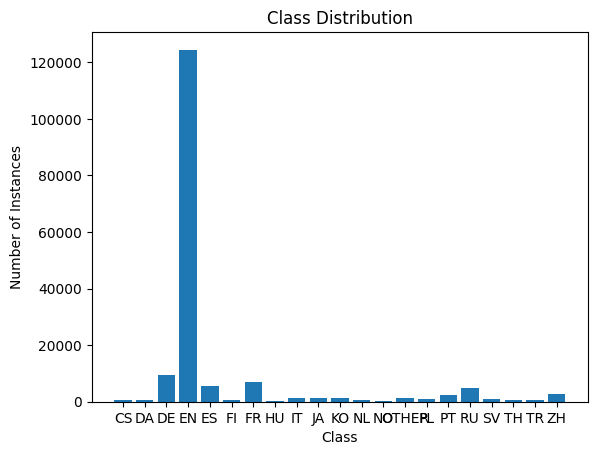

In [20]:

import matplotlib.pyplot as plt

# class labels
labels = [t.split("_")[1] for t in target ]

# number of instances for each class
instances = np.unique(np.argmax(y, axis=1), return_counts=True)[1]

# create bar chart
plt.bar(labels, instances)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.show()

## Compute class weights

In [21]:
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(np.argmax(y, axis=1)),
                                    y=np.argmax(y, axis=1))
list(class_weight)

[13.898313492063492,
 15.915364953138313,
 0.8491120673980241,
 0.06434662989147721,
 1.4047075928107688,
 12.27826468010517,
 1.1774420608072615,
 18.748076279692206,
 6.508478513356562,
 6.0327268812574015,
 6.5888300999412115,
 11.420012227430203,
 24.25887445887446,
 5.6021193641907425,
 8.480326876513317,
 3.156714736367733,
 1.660532788099683,
 9.374038139846103,
 12.666817359855335,
 10.369726128793486,
 2.8307738937159024]

## Edge index

In [22]:
adj = nx.to_scipy_sparse_array(G).tocoo()
row = torch.from_numpy(adj.row.astype(np.int64))
col = torch.from_numpy(adj.col.astype(np.int64))
edge_index = torch.stack([row, col], dim=0)
del adj

In [23]:
print(X.shape)
print(y.shape)
print(edge_index.shape)

(168114, 12)
(168114, 21)
torch.Size([2, 13595114])


## Create dataset

In [24]:

from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, InMemoryDataset, Dataset
from torch_geometric.loader import DataLoader

class CustomDataset(InMemoryDataset):
    def __init__(self, transform=None):
        super(CustomDataset, self).__init__('.', transform, None, None)

        data = Data(edge_index=edge_index)
        data.x = torch.from_numpy(X).type(torch.float32)
        data.y = torch.from_numpy(y).type(torch.float32)
        data.num_classes = len(y[0])

        # integer_encoded = np.argmax(y, axis=1)

        # X_train, X_test, y_train, y_test = train_test_split(pd.Series(X[:,0]),
        #                                                     pd.Series(y[:,0]),
        #                                                     test_size=0.20,
        #                                                     stratify=integer_encoded,
        #                                                     random_state=42)
        # # create train and test masks for data
        # train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        # test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        # train_mask[X_train.index] = True
        # test_mask[X_test.index] = True
        # data['train_mask'] = train_mask
        # data['test_mask'] = test_mask

        self.data, self.slices = self.collate([data])

## Dataset info

In [25]:
dataset = CustomDataset()
data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Number of training nodes: {data.train_mask.sum()}')
# print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(edge_index=[2, 13595114], x=[168114, 12], y=[168114, 21], num_classes=21)
Number of nodes: 168114
Number of edges: 13595114
Average node degree: 80.87
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [26]:
# import random
# from torch_geometric.utils import to_networkx
# import networkx as nx

# n_sample = 2000
# y_enc = np.argmax(data.y.numpy(), axis=1)

# sampled_nodes = np.random.choice(G.nodes, n_sample)
# G_sub = G.subgraph(sampled_nodes)
# y_sub = y_enc[G_sub.nodes]


# plt.figure(figsize=(9, 7))
# nx.draw_spring(G_sub, node_size=30, arrows=False, node_color=y_sub)
# plt.show() 
    


In [27]:
import torch_geometric.transforms as T

split = T.RandomNodeSplit(num_val=0.1,  num_test=0.2)
data = split(data)

In [28]:
data

Data(edge_index=[2, 13595114], x=[168114, 12], y=[168114, 21], num_classes=21, train_mask=[168114], val_mask=[168114], test_mask=[168114])

# Models

In [29]:
from torchmetrics import AUROC, Accuracy
def train_node_classifier(model, graph, optimizer, criterion, n_epochs=200):

    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out, _ = model(graph)
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
        loss.backward()
        optimizer.step()

        pred = out.argmax(dim=1)
        acc, auc = eval_node_classifier(model, graph, graph.val_mask)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val Acc: {acc:.3f}, Val AUC: {auc:.3f}')

    return model


def eval_node_classifier(model, data, mask):

    model.eval()
    preds, _ = model(data)
    preds = preds[data.test_mask]
    trues = data.y.argmax(dim=1)[data.test_mask]
    accuracy = Accuracy(task="multiclass", num_classes=dataset.num_classes).to(device)
    acc = accuracy(preds.argmax(dim=1),  trues)

    auroc = AUROC(task="multiclass", num_classes=dataset.num_classes).to(device)
    auc = auroc(preds,  trues)
    return acc, auc
  

In [30]:
def visualize_features(model, data, device, n):
  model.to(device)
  model.eval()
  data.to(device)

  _, features = model(data)
  y_enc = np.argmax(data.y.cpu().detach().numpy(), axis=1)
  visualize(features[:n], color=y_enc[:n])

Device

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
data.to(device)

Data(edge_index=[2, 13595114], x=[168114, 12], y=[168114, 21], num_classes=21, train_mask=[168114], val_mask=[168114], test_mask=[168114])

## GNN SAGEConv

In [46]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class SAGE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = SAGEConv(dataset.num_features, 16)
        self.conv2 = SAGEConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.tanh(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        
        return x, x

sage = SAGE().to(device)
print(sage)

SAGE(
  (conv1): SAGEConv(12, 16, aggr=mean)
  (conv2): SAGEConv(16, 21, aggr=mean)
)


### Evaluate before training

In [47]:
test_acc, test_auc = eval_node_classifier(sage, data, data.test_mask)
print(f'Test Acc: {test_acc:.3f}, Test auc: {test_auc:.3f}')

Test Acc: 0.007, Test auc: 0.486


### Visualization of the node embeddings before training

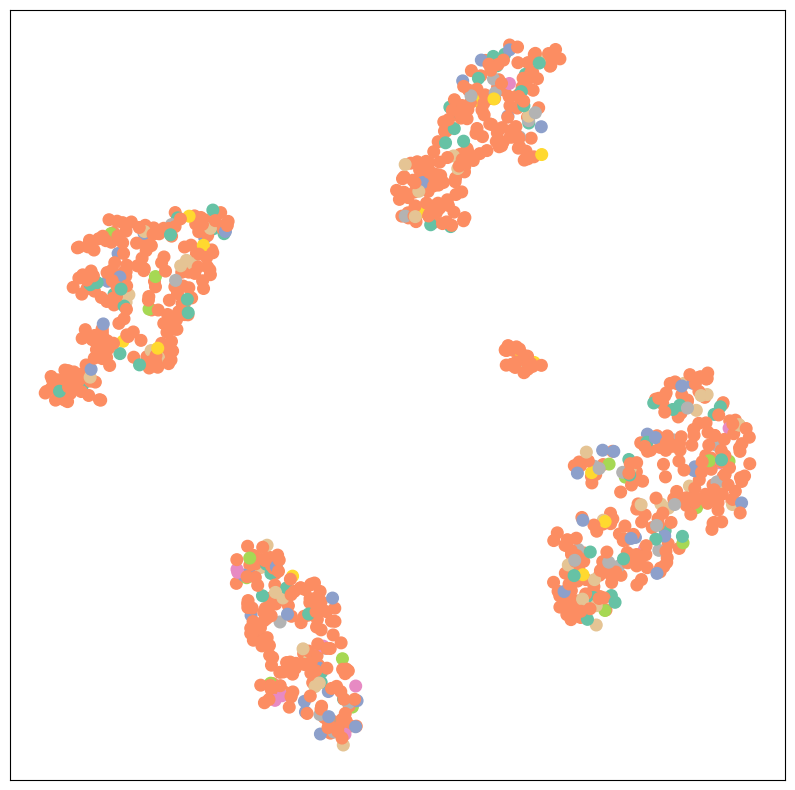

In [48]:
visualize_features(sage, data, device, 1000)

### Training

In [49]:
optimizer = torch.optim.Adam(sage.parameters(), lr=0.01, weight_decay=5e-4)

class_weights = torch.FloatTensor(class_weight).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

sage = train_node_classifier(sage, data, optimizer, criterion, n_epochs=100)


Epoch: 010, Train Loss: 3.018, Val Acc: 0.019, Val AUC: 0.578
Epoch: 020, Train Loss: 2.973, Val Acc: 0.138, Val AUC: 0.615
Epoch: 030, Train Loss: 2.928, Val Acc: 0.076, Val AUC: 0.624
Epoch: 040, Train Loss: 2.900, Val Acc: 0.048, Val AUC: 0.625
Epoch: 050, Train Loss: 2.884, Val Acc: 0.041, Val AUC: 0.625
Epoch: 060, Train Loss: 2.881, Val Acc: 0.049, Val AUC: 0.625
Epoch: 070, Train Loss: 2.876, Val Acc: 0.047, Val AUC: 0.626
Epoch: 080, Train Loss: 2.876, Val Acc: 0.049, Val AUC: 0.628
Epoch: 090, Train Loss: 2.872, Val Acc: 0.047, Val AUC: 0.630
Epoch: 100, Train Loss: 2.875, Val Acc: 0.045, Val AUC: 0.629


### Evaluate after training

In [50]:
test_acc, test_auc = eval_node_classifier(sage, data, data.test_mask)
print(f'Test Acc: {test_acc:.3f}, Test auc: {test_auc:.3f}')

Test Acc: 0.045, Test auc: 0.629


### Visualization of the node embeddings after training

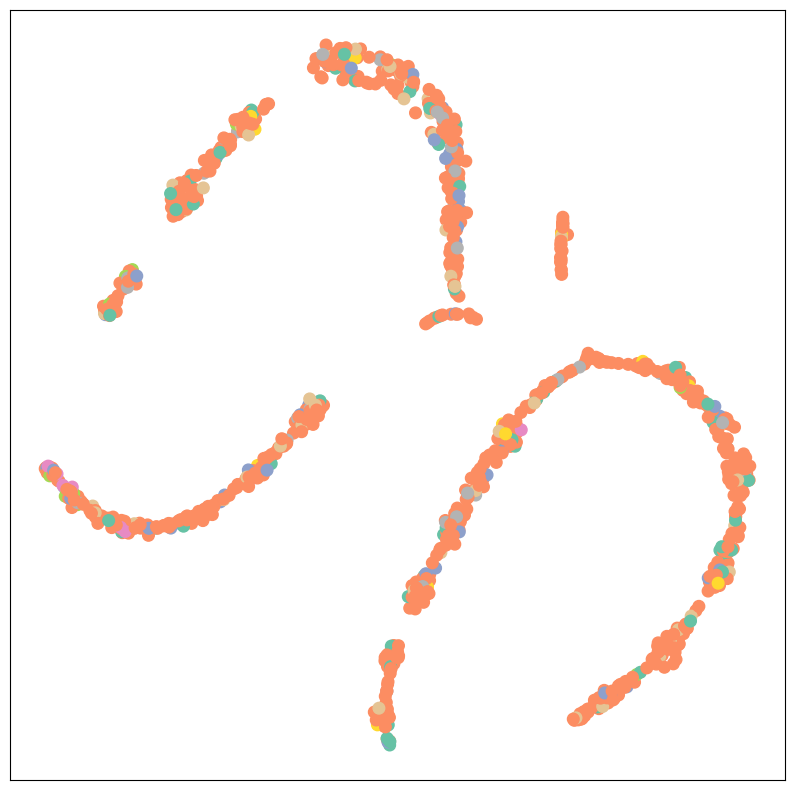

In [51]:
visualize_features(sage, data, device, 1000)

## GNN GATConv

In [59]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, 16)
        self.classifier = nn.Linear(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.tanh(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.classifier(x)

        return x, x

gat = GAT().to(device)
print(gat)

GAT(
  (conv1): GATConv(12, 16, heads=1)
  (classifier): Linear(in_features=16, out_features=21, bias=True)
)


### Evaluate before training

In [60]:
test_acc, test_auc = eval_node_classifier(gat, data, data.test_mask)
print(f'Test Acc: {test_acc:.3f}, Test auc: {test_auc:.3f}')

Test Acc: 0.028, Test auc: 0.508


### Visualization of the node embeddings before training

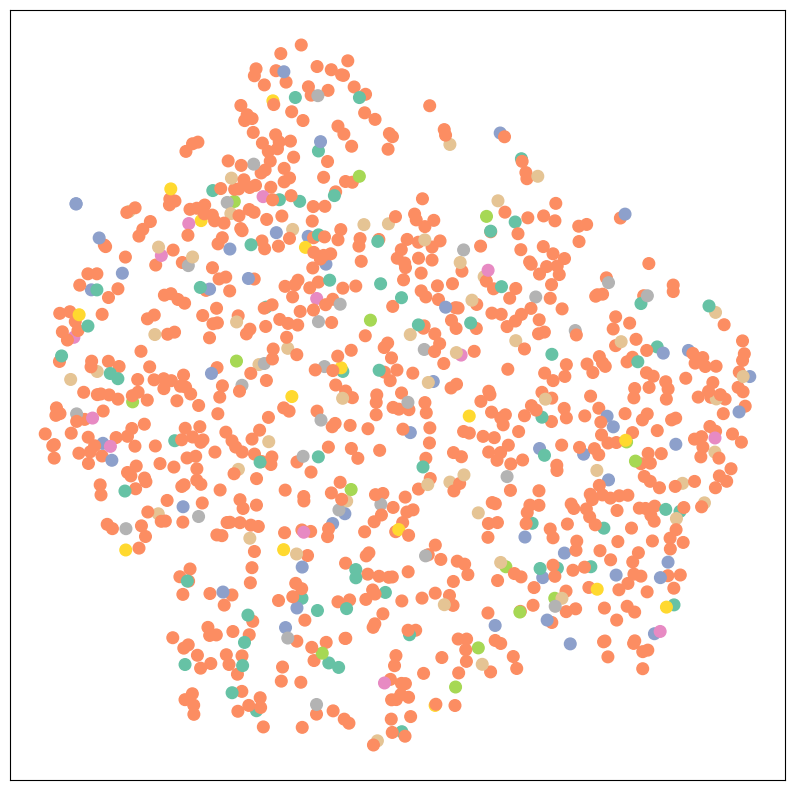

In [61]:
visualize_features(gat, data, device, 1000)

### Training

In [63]:
optimizer = torch.optim.Adam(gat.parameters(), lr=0.01, weight_decay=5e-4)

class_weights = torch.FloatTensor(class_weight).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

gat = train_node_classifier(gat, data, optimizer, criterion, n_epochs=20)


Epoch: 010, Train Loss: 3.032, Val Acc: 0.023, Val AUC: 0.516
Epoch: 020, Train Loss: 3.024, Val Acc: 0.009, Val AUC: 0.522


### Evaluate after training

In [64]:
test_acc, test_auc = eval_node_classifier(gat, data, data.test_mask)
print(f'Test Acc: {test_acc:.3f}, Test auc: {test_auc:.3f}')

Test Acc: 0.009, Test auc: 0.522


### Visualization of the node embeddings after training

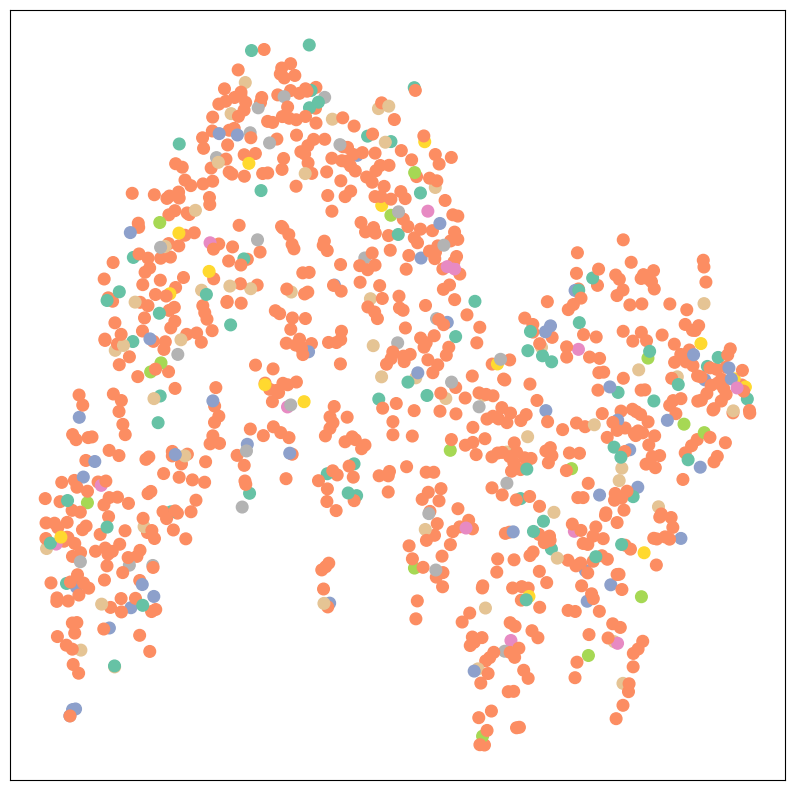

In [65]:
visualize_features(gat, data, device, 1000)